# Load Synth Data

In [110]:
import pandas as pd
import torch, transformer_lens, itertools, tqdm
from functools import partial
from measureLM import visualizing, decoding, patching, scoring

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import seaborn as sns
import numpy as np

from measureLM import helpers

## Load Data

In [96]:
df = pd.read_excel(helpers.ROOT_DIR / "data" / "friend_enemy_list.xlsx")
df

,ent1,ent2,label,type
0,Sherlock Holmes,James Moriarty,enemy,movie
1,Obi Wan Kenobi,Darth Maul,enemy,movie
2,Harry Potter,Lord Voldemort,enemy,movie
3,Harry Potter,Draco Malfoy,enemy,movie
4,Spiderman,Norman Osborne,enemy,movie
...,...,...,...,...
69,Larry Page,Sergei Brin,friend,business
70,USA,Israel,friend,history
71,Mike Wazowski,James P. Sullivan,friend,movie
72,Sherlock Holmes,John Watson,friend,movie


## Analyse

In [97]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-large").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer
Moving model to device:  cpu


In [151]:
class Default(dict):
    def __missing__(self, key):
        return '{' + key + '}'

    
def select_logits(logits, scale): 
    indices = torch.LongTensor([model.tokenizer.encode(f" {token}")[0] for token in scale])
    logits = torch.index_select(logits[...,-1,:], -1, indices)
    logits_normed = logits / logits.sum()
    return logits_normed[...,0].item() 


def apply_scales(logits, scales):
    scale_vals, scale_name  = [],[]
    for scale in scales:
        value = select_logits(logits, scale)
        scale_vals.append(value)
        scale_name.append("_".join(scale))
    return torch.tensor(scale_vals), scale_name


def compute_measurement(kwargs, prompt, model, scales):
    
    prompt = prompt.format_map(Default(kwargs))
    logits, activs = model.run_with_cache(prompt)
    scale_vals_forward, scale_name = apply_scales(logits, scales)

    prompt = prompt.format_map(Default(kwargs))
    logits, activs = model.run_with_cache(prompt)
    scale_vals_backward, scale_name = apply_scales(logits, scales)
    
    scale_vals = (scale_vals_forward + scale_vals_backward) / 2
    return scale_vals.tolist(), scale_name  
    

scales = [["friendly", "hostile"],["positive", "negative"]]
prompt = "The relationship between {ent1} and {ent2} is"


all_scale_vals, all_scale_names = [], []
for (ent1, ent2) in tqdm.tqdm(list(zip(df["ent1"].to_list(), df["ent2"].to_list()))):
    scale_vals, scale_name = compute_measurement({"ent1": ent1,"ent2": ent2}, prompt, model, scales)
    all_scale_vals.append(scale_vals)
    all_scale_names.append(scale_name)

df[all_scale_names[0]] = np.array(all_scale_vals)
df

100%|███████████████████████████████████████████| 74/74 [00:44<00:00,  1.66it/s]


,level_0,index,ent1,ent2,label,type,friendly_hostile,positive_negative
0,0,30,Nazi Germany,Allied Forces,enemy,history,0.444050,0.510559
1,1,28,Gauls,Rome,enemy,history,0.448044,0.512050
2,2,23,Winston Churchill,Adolf Hitler,enemy,history,0.482942,0.499975
3,3,31,Cain,Abel,enemy,history,0.486396,0.519338
4,4,24,Harry Trumann,Nikita Khrushchev,enemy,history,0.490835,0.512566
...,...,...,...,...,...,...,...,...
69,69,63,Woody,Buzz Lightyear,friend,movie,0.574652,0.558429
70,70,12,Green Bay Packers,Chicago Bears,enemy,sports,0.576593,0.531570
71,71,68,Bill Gates,Paul Allen,friend,business,0.579126,0.574798
72,72,13,Borussia Dortmund,FC Bayern Munich,enemy,sports,0.586116,0.556648


In [156]:
scale_name = "friendly_hostile"
df = df.sort_values(scale_name)
df = df.reset_index(drop=True)

ent1, ent2, labels = df["ent1"].to_list(), df["ent2"].to_list(), df["label"].to_list()
ent1_2 = [f"{e1}–{e2}" for e1, e2 in list(zip(ent1, ent2))]
vals = df[scale_name].to_numpy()
x_vals = np.arange(0, len(vals))

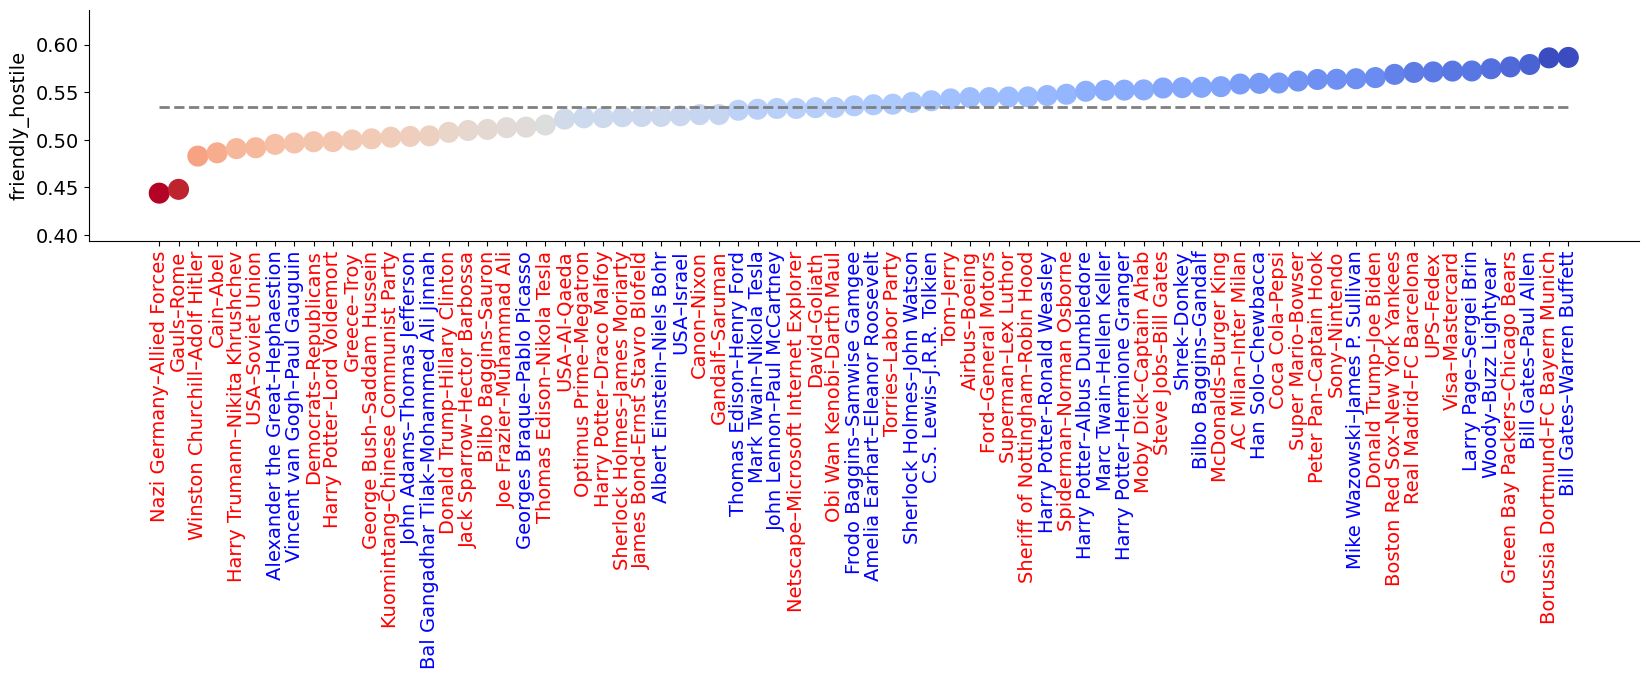

In [157]:
# Draw plot
titlefont = 20
labelfont = 14

fig, ax = plt.subplots(1, 1, figsize=(20, 3), gridspec_kw={'hspace': 0.4})
ax.scatter(x_vals, vals, s=200, alpha=1.0, c=vals, cmap=cm.coolwarm_r)
ax.hlines(y=vals.mean(), xmin=x_vals.min(), xmax=x_vals.max(), linewidth=2, linestyle= '--', color='grey')
#for x, y in zip(x_vals, vals):
    #t = ax.text(x, y, round(y, 1), horizontalalignment='center', 
    #verticalalignment='center', fontdict={'color':'white'})
    
ax.xaxis.set_ticks(x_vals)
ax.tick_params(axis='both', which='major', labelsize=labelfont)
ax.set_ylim(vals.min() - 0.05, vals.max() + 0.05)
ax.set_xticklabels(ent1_2, fontsize=labelfont, rotation=90)
#ax.set_title(scale_name, fontsize=titlefont, color="black", loc='center')
ax.set_ylabel(scale_name, fontsize=labelfont)

for i, x_tick_label in enumerate(ax.get_xticklabels()):
    label = labels[i] 
    if label == "enemy":
        color = "red"
    elif label == "friend":
        color = "blue"
    x_tick_label.set_color(color)